In [1]:
# Import libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import nibabel as nib
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score
import SimpleITK as sitk
import six
from radiomics import featureextractor 
import numpy as np
import os
import pickle
import pandas as pd
import logging
from scipy.stats import linregress
from sklearn.linear_model import QuantileRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RANSACRegressor
import os
import sys
sys.path.append('../')
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing as skp
from sklearn import model_selection as sms
from sklearn import feature_selection as skf
from sklearn import linear_model as slm
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
import nibabel as nib
import os
import pickle
from torch import nn
import gc
from neuroCombat import neuroCombat
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
cv_names = {'CORNELL ID',
            ' OFF (pre-dbs updrs)',
            ' ON (pre-dbs updrs)',
            ' OFF meds ON stim 6mo',
            'Age',
            'Sex',
            'Ethnicity',
            'Race',
            'Disease Duration (year)',
            'Physician',
            ' pre op levadopa equivalent dose (mg)',
            ' Location',
            ' Target',
            ' Test medication status'}


# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/dbs_03292024.csv'
motor_df = util.filter_data(file_dir,cv_names,True)
# Find cases with all required scores
cv_dict = util.filter_cases(motor_df,cv_names)
subs = cv_dict['CORNELL ID']
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/new/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/new/phi/'
roi_path = '/home/ali/RadDBS-QSM/data/xlxs/new_segs.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)
print(np.unique(R_all))
ids = np.asarray(ID_all).astype(int)

# Use cases from only 1 rater
phys = cv_dict['Physician']
# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(ids).astype(int),np.asarray(cv_dict['CORNELL ID'])[phys==1].astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
# Exclude GPi
c_cases_idx[ids == 9] = 0
c_cases_idx[ids == 36] = 0
# c_cases_idx[ids == 42] = 0
# c_cases_idx[ids == 52] = 0
c_cases_idx[ids == 53] = 0
# c_cases_idx[ids == 98] = 0
# c_cases_idx[ids == 108] = 0
print(np.sum(c_cases_idx))
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
print(len(s_cases_idx))
        
X_all_c = X_all[c_cases_idx,2:6,:]
# X_all_c = (np.load('X2h.npy').T).reshape((61,6381))
# print('Applying combat')
K_all_c = K_all[c_cases_idx,2:6,:]
R_all_c = R_all[c_cases_idx,2:6,:]
# Re-index the scored subjects with respect to complete cases

per_change = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' OFF meds ON stim 6mo'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_imp = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' ON (pre-dbs updrs)'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_updrs = cv_dict[' OFF (pre-dbs updrs)'][s_cases_idx]
dd = cv_dict['Disease Duration (year)'][s_cases_idx]
ledd = cv_dict[' pre op levadopa equivalent dose (mg)'][s_cases_idx]
tmed = cv_dict[' Test medication status'][s_cases_idx]

age = cv_dict['Age'][s_cases_idx]
loc = cv_dict[' Location'][s_cases_idx]
sex = cv_dict['Sex'][s_cases_idx]
rce = cv_dict['Race'][s_cases_idx]
eth = cv_dict['Ethnicity'][s_cases_idx]
tgt = cv_dict[' Target'][s_cases_idx]
subsc = subs[s_cases_idx]
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K_all_cu[:,:,-1] = 'disease_duration'
    K_all_cu[:,:,-1] = 'pre op levadopa equivalent dose (mg)'
    K_all_cu[:,:,-1] = ' Test medication status'
    K_all_cu[:,:,-1] = 'Physician'
    K_all_cu[:,:,-1] = 'Age'
    K_all_cu[:,:,-1] = 'Location'
    K_all_cu[:,:,-1] = 'Sex'
    K_all_cu[:,:,-1] = 'Race'
    K_all_cu[:,:,-1] = 'Ethnicity'
    
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K_all_c = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    R_all_c = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))

print(np.unique(R_all_c))

Keeping CORNELL ID
Keeping Age
Keeping Sex
Keeping Ethnicity
Keeping Race
Keeping Disease Duration (year)
Keeping Physician
Keeping  OFF (pre-dbs updrs)
Keeping  ON (pre-dbs updrs)
Keeping  pre op levadopa equivalent dose (mg)
Keeping  Location
Keeping  Target
Keeping  Test medication status
Keeping  OFF meds ON stim 6mo
{'Disease Duration (year)', ' Location', ' OFF meds ON stim 6mo', 'Sex', ' OFF (pre-dbs updrs)', ' pre op levadopa equivalent dose (mg)', 'Ethnicity', ' ON (pre-dbs updrs)', 'CORNELL ID', 'Age', 'Race', ' Target', ' Test medication status', 'Physician'}
['X_115_01.npy', 'X_115_02.npy', 'X_115_03.npy', 'X_115_04.npy', 'X_115_05.npy', 'X_115_06.npy', 'X_115_07.npy', 'X_115_08.npy', 'X_115_09.npy', 'X_115_10.npy', 'X_115_100.npy', 'X_115_101.npy', 'X_115_102.npy', 'X_115_104.npy', 'X_115_105.npy', 'X_115_106.npy', 'X_115_107.npy', 'X_115_108.npy', 'X_115_109.npy', 'X_115_11.npy', 'X_115_110.npy', 'X_115_111.npy', 'X_115_112.npy', 'X_115_113.npy', 'X_115_114.npy', 'X_115_1

In [3]:
R_gt0 = np.load('/home/ali/RadDBS-QSM/data/npy/old/R_chh.npy')
print(R_gt0)

['Background' 'Right substantia nigra' 'Right subthalamic nucleus'
 'Left subthalamic nucleus' 'Left substantia nigra'
 'Right dentate nucleus' 'Left dentate nucleus']


In [4]:
R_all_c

array([['Left substantia nigra', 'Left substantia nigra',
        'Left substantia nigra', ..., 'Right subthalamic nucleus',
        'Right subthalamic nucleus', 'Right subthalamic nucleus'],
       ['Left substantia nigra', 'Left substantia nigra',
        'Left substantia nigra', ..., 'Right subthalamic nucleus',
        'Right subthalamic nucleus', 'Right subthalamic nucleus'],
       ['Left substantia nigra', 'Left substantia nigra',
        'Left substantia nigra', ..., 'Right subthalamic nucleus',
        'Right subthalamic nucleus', 'Right subthalamic nucleus'],
       ...,
       ['0.0', '0.0', '0.0', ..., '0.0', '0.0', '0.0'],
       ['0.0', '0.0', '0.0', ..., '0.0', '0.0', '0.0'],
       ['0.0', '0.0', '0.0', ..., '0.0', '0.0', '0.0']], dtype='<U32')

In [5]:
np.unique(R_all_c[0])

array(['Left substantia nigra', 'Left subthalamic nucleus',
       'Right Substantia nigra', 'Right subthalamic nucleus'],
      dtype='<U32')

In [6]:
# X0_gt0 = np.load('/home/ali/RadDBS-QSM/data/npy/old/X0_gt_chh_rois.npy')
# X0_gt0 = X0_gt0.reshape((37,6,1596))
# X0_gt0 = X0_gt0[:,0:4,:-1]
# pre_updrs_1 = np.asarray(['53', '32', '58', '62', '34', '57', '100', '43', '62', '64', '94',
#        '67', '26', '25', '71', '51', '49', '49', '31', '41', '35', '61',
#        '78', '51', '60', '79', '85', '43', '54', '61', '54', '93', '54',
#        '57', '49', '92', '54']).astype(float)
# X1 = X0_gt0.reshape(X0_gt0.shape[0],-1).T.astype(float)
# X2 = X_all_c.reshape(X_all_c.shape[0],-1).T.astype(float)
# # X2 = np.append(X2,pre_updrs.reshape(1,-1),axis=0)
# # X1 = np.append(X1,pre_updrs_1.reshape(1,-1),axis=0)

In [7]:
R_all.shape

(105, 6, 1595)

In [8]:
X0_gt0 = np.load('/home/ali/RadDBS-QSM/data/npy/old/X0_gt_chh_rois.npy')
X0_gt0 = X0_gt0.reshape((37,6,1596))
X0_gt0 = X0_gt0[:,0:4,:-1]
pre_updrs_1 = np.asarray(['53', '32', '58', '62', '34', '57', '100', '43', '62', '64', '94',
       '67', '26', '25', '71', '51', '49', '49', '31', '41', '35', '61',
       '78', '51', '60', '79', '85', '43', '54', '61', '54', '93', '54',
       '57', '49', '92', '54']).astype(float)
X1 = X0_gt0.reshape(X0_gt0.shape[0],-1).T.astype(float)
X0_gt = np.zeros_like(X_all_c)
X0_gt[:,0,:] = X_all_c[:,2,:]
X0_gt[:,1,:] = X_all_c[:,3,:]
X0_gt[:,2,:] = X_all_c[:,1,:]
X0_gt[:,3,:] = X_all_c[:,0,:]
X2 = X_all_c.reshape(X0_gt.shape[0],-1).T.astype(float)
# X2 = np.append(X2,pre_updrs.reshape(1,-1),axis=0)
# X1 = np.append(X1,pre_updrs_1.reshape(1,-1),axis=0)

In [9]:
data = np.hstack((X1,X2))
# Specifying the batch (scanner variable) as well as a biological covariate to preserve:
covars = {'batch':np.hstack((np.repeat(1,X1.shape[1]),np.repeat(2,X2.shape[1]))).tolist()}
        #   'gender':[1,2,1,2,1,2,1,2,1,2]} 
covars = pd.DataFrame(covars)  

# To specify the name of the variable that encodes for the scanner/batch covariate:
batch_col = 'batch'

#Harmonization step:
data_combat = neuroCombat(dat=data,
    covars=covars,
    ref_batch=None,
    parametric=False,
    eb=False,
    batch_col=batch_col)["data"]

[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding L/S adjustments without Empirical Bayes
[neuroCombat] Final adjustment of data


In [10]:
X2h = data_combat[:,37:]
print(X2h.shape)
np.mean((X2-X2h)**2)

(6380, 30)


5.906842552710253e+18

In [11]:
np.save('/home/ali/RadDBS-QSM/src/jupyter/archive/npy/X2h_sr.npy',X2h)

Text(0.5, 0, 'Feature value')

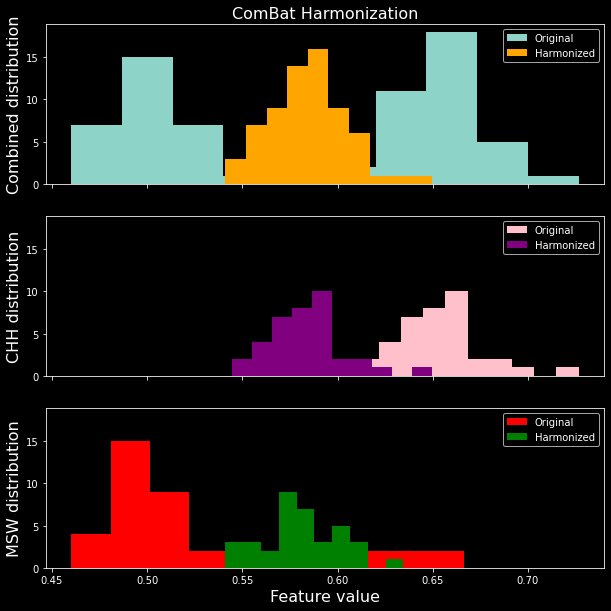

In [12]:
plt.style.use('dark_background')
fig,ax = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10,10))
v = 10
ax[0].set_title('ComBat Harmonization',fontsize=16)
ax[0].hist(data[v,:],label='Original')
ax[0].hist(data_combat[v,:],color='orange',label='Harmonized')
ax[0].set_ylabel('Combined distribution',fontsize=16)
ax[0].legend(bbox_to_anchor=(1, 1),loc='upper right')
ax[1].hist(data[v,:37],color='pink',label='Original')
ax[1].hist(data_combat[v,:37],color='purple',label='Harmonized')
ax[1].legend(bbox_to_anchor=(1, 1),loc='upper right')
ax[1].set_ylabel('CHH distribution',fontsize=16)
ax[2].hist(data[v,31:],color='red',label='Original')
ax[2].hist(data_combat[v,31:],color='green',label='Harmonized')
ax[2].legend(bbox_to_anchor=(1, 1),loc='upper right')
ax[2].set_ylabel('MSW distribution',fontsize=16)
ax[2].set_xlabel('Feature value',fontsize=16)

